<a href="https://colab.research.google.com/github/xueenwu/Flixster/blob/master/Figure14_ODE2d_burgers_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python3 -m pip install pyDOE

  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18168 sha256=64e5c5f01b788b0a800e46c43d84c23780e691bdd836ca3ac944594be59a1c4d
  Stored in directory: /root/.cache/pip/wheels/ce/b6/d7/c6b64746dba6433c593e471e0ac3acf4f36040456d1d160d17
Successfully built pyDOE


In [2]:
#@title Import

import sys
import jax.config as config
import jax.numpy as jnp
import numpy as np
import optax
from jax import random, jit, vjp, grad, vmap, pmap
import jax.flatten_util as flat_utl
from jax.experimental.host_callback import call
from tensorflow_probability.substrates import jax as tfp
import tensorflow as tf
from pyDOE import lhs
import time
import functools
import scipy.io
from pathlib import Path
import matplotlib.pyplot as plt

In [44]:
#@title Neural Net Functions

# initialize the neural network weights and biases
def init_MLP(parent_key, layer_widths):
    params = []
    keys = random.split(parent_key, num=len(layer_widths) - 1)
    # create the weights and biases for the network
    for in_dim, out_dim, key in zip(layer_widths[:-1], layer_widths[1:], keys):
        weight_key, bias_key = random.split(key)
        xavier_stddev = jnp.sqrt(2 / (in_dim + out_dim))
        params.append(
            [random.truncated_normal(weight_key, -2, 2, shape=(in_dim, out_dim)) * xavier_stddev,
             random.truncated_normal(bias_key, -2, 2, shape=(out_dim,)) * xavier_stddev]
        )
    return params


# define the basic formation of neural network
def neural_net(params, z, limit, scl, act_s):
    '''
    :param params: weights and biases
    :param z: input data [matrix with shape [N, m]]; m is number of inputs)
    :param limit: characteristic scale for normalization [matrix with shape [2, m]]
    :param scl: scale factor to scale gradient
    :param act_s: activation function for the first layer: 0 corresponds to tanh and 1 corresponds to sin
    :return: neural network output [matrix with shape [N, n]]; n is number of outputs)
    '''
    lb = limit[0]  # lower bound for each input
    ub = limit[1]  # upper bound for each input

    # choose the activation function
    actv = [jnp.tanh, jnp.sin][act_s]
    # normalize the input
    H = 2.0 * (z - lb) / (ub - lb) - 1.0
    # separate the first, hidden and last layers
    first, *hidden, last = params
    # calculate the first layers output with right scale
    H = actv(jnp.dot(H, first[0]) * scl + first[1])
    # calculate the middle layers output
    for layer in hidden:
        H = jnp.tanh(jnp.dot(H, layer[0]) + layer[1])
    # no activation function for last layer
    var = jnp.dot(H, last[0]) + last[1]
    return var


# define sech function
def sech(z):
    return 1 / jnp.cosh(z)


# generate weights and biases for all variables of CLM problem
def sol_init_MLP(parent_key, n_hl, n_unit):
    '''
    :param n_hl: number of hidden layers [int]
    :param n_unit: number of units in each layer [int]
    '''
    layers = [2] + n_hl * [n_unit] + [1]
    # generate the random key for each network
    keys = random.split(parent_key, 1)
    # generate weights and biases for
    params_u = init_MLP(keys[0], layers)
    return dict(net_u=params_u)


# wrapper to create solution function with given domain size
def sol_pred_create(limit, scl, epsil, act_s = 0):
    '''
    :param limit: domain size of the input
    :return: function of the solution (a callable)
    '''
    def f_u(params, z):
        # generate the NN
        u = epsil * neural_net(params['net_u'], z, limit, scl, act_s)
        return u
    return f_u


def mNN_pred_create(f_u, limit, scl, epsil, act_s=0):
    '''
    :param f_u: sum of previous stage network
    :param limit: domain size of the input
    :return: function of the solution (a callable)
    '''
    def f_comb(params, z):
        # generate the NN
        u_now = neural_net(params['net_u'], z, limit, scl, act_s)
        u = f_u(z) + epsil * u_now
        return u
    return f_comb


"""Low-level functions developed for PINN training using JAX"""

# define the mean squared error
# def ms_error(diff):
#     return jnp.mean(jnp.square(diff), axis=0)

#     loss_d = tf.reduce_mean(tf.abs(tf.pow(self.u - self.u_pred, [self.p]))) # Gets the MSE, reduce mean reduces dimensions to zero
#     loss_d = tf.pow(loss_d, 2 / self.p)

def lp2_error(diff, p = 2):
    # Returns (1/N * sum(diff^p))^(2/p) so it has the same order of magnitude as MSE
    loss = jnp.power(diff, p)
    loss = jnp.mean(loss, axis = 0)
    loss = jnp.power(loss, 2 / p)
    loss = jnp.power(jnp.mean(jnp.abs(jnp.power(diff, p)), axis = 0), 2 / p)
    return loss

# # define the mean squared error with weights
# def ms_bias(diff, weight):
#     mdiff = 5 * jnp.tanh(0.2*diff) * weight
#     return jnp.mean(jnp.square(mdiff), axis=0)


# generate matrix required for vjp for vector gradient
def vgmat(z, n_out, idx=None):
    '''
    :param n_out: number of output variables
    :param idx: indice (list) of the output variable to take the gradient
    '''
    if idx is None:
        idx = range(n_out)
    # obtain the number of index
    n_idx = len(idx)
    # obtain the number of input points
    n_pt = z.shape[0]
    # determine the shape of the gradient matrix
    mat_shape = [n_idx, n_pt, n_out]
    # create the zero matrix based on the shape
    mat = jnp.zeros(mat_shape)
    # choose the associated element in the matrix to 1
    for l, ii in zip(range(n_idx), idx):
        mat = mat.at[l, :, ii].set(1.)
    return mat


# vector gradient of the output with with input
def vectgrad(func, z):
    # obtain the output and the gradient function
    sol, vjp_fn = vjp(func, z)
    # determine the mat grad
    mat = vgmat(z, sol.shape[1])
    # calculate the gradient of each output with respect to each input
    grad_sol = vmap(vjp_fn, in_axes=0)(mat)[0]
    # calculate the total partial derivative of output with input
    n_pd = z.shape[1] * sol.shape[1]
    # reshape the derivative of output with input
    grad_all = grad_sol.transpose(1, 0, 2).reshape(z.shape[0], n_pd)
    return grad_all, sol


# governing equation
def gov_eqn(f_u, x, nu=1):
    u_g, u = vectgrad(f_u, x)
    u_t = u_g[:, 0:1]
    u_x = u_g[:, 1:2]

    fu_x = lambda x: vectgrad(f_u, x)[0][:, 1:2]
    # calculate the output and its derivative with original coordinates
    u_xx = vectgrad(fu_x, x)[0][:, 1:2]
    # calculate the residue of the CCF equation
    f = u_t + u*u_x - nu * u_xx
    return f

def gov_deri_eqn(f_u, z, nu):
    # allocate the value to each variable
    fc_res = lambda z: gov_eqn(f_u, z, nu)
    # calculate the residue of higher derivative of CCF equation
    dfunc = lambda z: vectgrad(fc_res, z)[0]
    # calculate the residue of the first and second derivative of CCF equation
    d2f, df = vectgrad(dfunc, z)
    return df, d2f

def loss_create(predf_u, nu, lw, loss_ref, p):
    '''
    a function factory to create the loss function based on given info
    :param loss_ref: loss value at the initial of the training
    :return: a loss function (callable)
    '''

    # loss function used for the PINN training
    def loss_fun(params, data):
        # create the function for gradient calculation involves input Z only
        f_u = lambda z: predf_u(params, z)
        # load the data of normalization condition
        z_bd = data['cond_bd'][0]
        u_bd = data['cond_bd'][1]

        # load the position and weight of collocation points
        z_col = data['z_col']

        # calculate the gradient of phi at origin
        u_bd_p = f_u(z_bd)

        # calculate the residue of equation
        f = gov_eqn(f_u, z_col, nu)
        # calculate the residue of first and second derivative
        # df, d2f = gov_deri_eqn(f_u, z_col)

        # calculate the L_p^2 error of normalization cond.
        norm_err = lp2_error(diff = u_bd_p - u_bd, p = p)
        # calculate the error of far-field exponent cond.
        data_err = jnp.hstack([norm_err])

        # calculate the mean squared root error of equation
        eqn_err_f = lp2_error(diff = f, p = p)
        # eqn_err_df = ms_error(df)
        # eqn_err_d2f = ms_error(d2f)
        eqn_err = jnp.hstack([eqn_err_f])

        # set the weight for each condition and equation
        data_weight = jnp.array([1.])
        eqn_weight = jnp.array([1.])

        # calculate the overall data loss and equation loss
        loss_data = jnp.sum(data_err * data_weight)
        loss_eqn = jnp.sum(eqn_err * eqn_weight)

        # calculate the total loss
        loss = (loss_data + lw[0] * loss_eqn) / loss_ref
        # group the loss of all conditions and equations
        loss_info = jnp.hstack([jnp.array([loss, loss_data, loss_eqn]),
                                data_err, eqn_err])
        return loss, loss_info
    return loss_fun

def loss_create_lbfgs(loss_f, weights):
    # loss function used for the PINN training
    def loss_fun(params, data):
        loss, loss_info = loss_f(params, weights, data)
        return loss, loss_info
    return loss_fun

# create the Adam minimizer
@functools.partial(jit, static_argnames=("lossf", "opt"))
def adam_minimizer(lossf, params, data, opt, opt_state):
    """Basic gradient update step based on the opt optimizer."""
    grads, loss_info = grad(lossf, has_aux=True)(params, data)
    updates, opt_state = opt.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, loss_info, opt_state

def adam_optimizer(lossf, params, data, epoch, lr=1e-3):
    # select the Adam as the minimizer
    opt_Adam = optax.adam(learning_rate=lr)
    # obtain the initial state of the params
    opt_state = opt_Adam.init(params)
    # pre-allocate the loss varaible
    loss_all = []
    nc = jnp.int32(jnp.round(epoch / 5))
    # start the training iteration
    for step in range(epoch):
        # minimize the loss function using Adam
        params, loss_info, opt_state = adam_minimizer(lossf, params, data, opt_Adam, opt_state)
        # print the loss for every 100 iterations
        if step % 10 == 0:
            print(f"Step: {step} | Loss: {loss_info[0]:.4e} |"
                  f" Loss_d: {loss_info[1]:.4e} | Loss_e: {loss_info[2]:.4e}", file=sys.stderr)
        # saving the loss
        loss_all.append(loss_info[0:3])

        ## Question: what does this do?
        if step % 10000 == 0 and step > 0:
            lr = lr
            opt_Adam = optax.adam(learning_rate=lr)

    # obtain the total loss in the last iterations
    lossend = jnp.array(loss_all[-nc:])[:, 0]
    # find the minimum loss value
    lmin = jnp.min(lossend)
    # optain the last loss value
    llast = lossend[-1]
    # guarantee the loss value in last iteration is smaller than anyone before
    while llast > lmin:
        params, loss_info, opt_state = adam_minimizer(lossf, params, data, opt_Adam, opt_state)
        llast = loss_info[0]
        # saving the loss
        loss_all.append(loss_info[0:3])

    return params, loss_all

# A factory to create a function required by tfp.optimizer.lbfgs_minimize.
def lbfgs_function(lossf, init_params, data):
    # obtain the 1D parameters and the function that can turn back to the pytree
    _, unflat = flat_utl.ravel_pytree(init_params)

    def update(params_1d):
        # updating the model's parameters from the 1D array
        params = unflat(params_1d)
        return params

    # A function that can be used by tfp.optimizer.lbfgs_minimize.
    @jit
    def f(params_1d):
        # convert the 1d parameters back to pytree format
        params = update(params_1d)
        # calculate gradients and convert to 1D tf.Tensor
        grads, loss_info = grad(lossf, has_aux=True)(params, data)
        # convert the grad to 1d arrays
        grads_1d = flat_utl.ravel_pytree(grads)[0]
        loss_value = loss_info[0]

        # # store loss value so we can retrieve later
        call(lambda x: f.loss.append(x), loss_info[0:3], result_shape=None)
        call(lambda x: print(f"Step: NaN | Loss: {x[0]:.4e} |"
                  f" Loss_d: {x[1]:.4e} | Loss_e: {x[2]:.4e}"), loss_info)
        return loss_value, grads_1d

    # store these information as members so we can use them outside the scope
    f.update = update
    f.loss = []
    return f

# define the function to apply the L-BFGS optimizer
def lbfgs_optimizer(lossf, params, data, epoch):
    func_lbfgs = lbfgs_function(lossf, params, data)
    # convert initial model parameters to a 1D array
    init_params_1d = flat_utl.ravel_pytree(params)[0]
    # calculate the effective number of iteration
    max_nIter = jnp.int32(epoch / 3) # question: why is it / 3?
    # train the model with L-BFGS solver
    results = tfp.optimizer.lbfgs_minimize(
        value_and_gradients_function=func_lbfgs, initial_position=init_params_1d,
        tolerance=1e-10, max_iterations=max_nIter)
    params = func_lbfgs.update(results.position)
    # history = func_lbfgs.loss
    num_iter = results.num_objective_evaluations
    loss_all = func_lbfgs.loss
    print(f" Total iterations: {num_iter}")
    return params, loss_all

"""
Define initial and boundary conditions
"""
def data_func_create_burger(N_col, N_bd, ds):
    # generate the weights for boundary and collocation points
    w_bd = jnp.ones([N_bd*4, 1])
    w_col = jnp.ones([N_col+N_bd*4, 1])
    weight = dict(w_bd=w_bd, w_col=w_col)

    # define the function that can re-sample collocation points each time it's called calling
    def dataf():
        # set the initial and boundary conditions
        tx0 = lhs(2, N_bd) * jnp.array([1, 0]) + jnp.array([0, -1])
        ux0 = 0 * jnp.ones(N_bd)[:, None]

        tx1 = lhs(2, N_bd) * jnp.array([1, 0]) + jnp.array([0, 1])
        ux1 = 0 * jnp.ones(N_bd)[:, None]

        t0x = (2 * lhs(2, 2*N_bd) - 1) * jnp.array([0, 1])
        ut0 = -jnp.sin(jnp.pi * t0x[:, 1:2])

        # group the initial and boundary conditions
        x_bd = jnp.vstack([tx0, tx1, t0x])
        u_bd = jnp.vstack([ux0, ux1, ut0])

        # prepare the collocation points
        x_col = lhs(2, N_col) * jnp.array([1, 2]) - jnp.array([0, 1])
        # add the collocation at the boundary
        x_col = jnp.vstack([x_col, x_bd])

        # group all the conditions and collocation points
        data = dict(z_col=x_col, cond_bd=[x_bd, u_bd])
        return data
    return dataf, weight




In [40]:
#@title Download Data

def init_turbulence_data(filename = '/content/drive/MyDrive/Stanford/FDNS Psi W_train_Re_1k.mat'):
  import numpy as np
  import h5py
  f = h5py.File(filename,'r')
  print(f)
  for key in f.keys():
      print(key) # Names of the root level object names in HDF5 file - can be groups or datasets.
      print(type(f[key])) # Get the object type: usually group or dataset

  # Get the HDF5 dataset; key needs to be a group name from above
  psi = np.array(f['Psi'][:])
  omega = np.array(f['W'][:])
  return psi, omega

In [84]:

#@title Plotter

######################################################################
############################# Plotting ###############################
######################################################################

class PINN_Plotter:
    def __init__(self, data = None, Z = None, pred_u = None, trained_params = None, loss_dict = None, rootdir = Path(), filename = {'loss': "loss.png", "results": "results.png"},
                 methods = None, n_iters = None, dpi = 300, precision = jnp.float64, fontsize = {'title': 15, 'subtitle': 12, 'axis': 10},
                 cmap = 'jet', show = True, burger_params = None, title = {'burger': "Predicted Burger's solution", 'energy_spectrum': "Energy spectrum"}):
        self.data = data
        self.Z = Z #input coordinates
        self.pred_u = pred_u #prediction function based on neural net
        self.trained_params = trained_params
        self.loss_dict = loss_dict #dictionary containing loss over time, with 'loss', 'loss_e', and 'loss_d'
        self.rootdir = rootdir
        self.filename = {k : str(rootdir.joinpath(f)) for k, f in filename.items()}
        self.methods = methods
        self.n_iters = n_iters
        self.dpi = dpi
        self.precision = precision
        self.fontsize = fontsize
        self.cmap = cmap
        self.show = show
        self.burger_params = burger_params
        self.title = title

    def plot_loss(self):
        figsize_loss_e = [8, 4]
        figsize = [3, 3]

        ## LOSS
        loss = self.loss_dict['loss']
        loss_d = self.loss_dict['loss_d']
        if "loss_e" in self.loss_dict:
            loss_e = self.loss_dict['loss_e']
            fig = plt.figure(figsize = figsize_loss_e, dpi = self.dpi)
            ax = plt.subplot(131)
        else:
            fig = plt.figure(figsize = figsize, dpi = self.dpi)
            ax = plt.subplot(111)

        # Set title of figure
        fig.suptitle(f'Loss', fontsize = self.fontsize['title'])#, method = {self.method}, n_iter = {self.n_iter}', fontsize = 15)

        def ax_properties(ax):
            ax.axhline(y=0, color = "k", linewidth = "0.5") #Add x- and y-axis line
            ax.axvline(x=0, color = "k", linewidth = "0.5")
            ax.set_yscale('log')
            ax.set_xlabel('Iteration', fontsize = 12)
            ax.set_xlim(left = 0, right = jnp.sum(jnp.array(self.n_iters)))
            return ax

        def plot_loss(ax, loss, y_label):
            ax.set_ylabel(y_label, fontsize = self.fontsize['subtitle'], rotation = 90)
            n = 0
            # Plot loss, labeled by optimization method
            for i, n_iter in enumerate(self.n_iters):
                ax.plot(jnp.arange(n, n + n_iter), loss[n:n + n_iter], '-', linewidth = 2, label = self.methods[i])
                n += n_iter

        ax = ax_properties(ax)
        plot_loss(ax = ax, loss = loss, y_label = "Total loss")
        ax.legend()

        if "loss_e" in self.loss_dict:
            ax = plt.subplot(132)
            ax = ax_properties(ax)
            plot_loss(ax = ax, loss = loss_d, y_label = "Data loss")

            ax = plt.subplot(133)
            ax = ax_properties(ax)
            plot_loss(ax = ax, loss = loss_e, y_label = "Equation loss")

        plt.tight_layout()
        plt.savefig(self.filename['loss'])
        if self.show:
            plt.show()
        plt.close('all')

    def plot_1d_pinn(self):
        #description, model, target_function, data_type, title, N_p, method = "", n_iter = "", gamma = ""):
        # plot_loss(model = model, method = method, n_iter = n_iter, include_equation_loss = True, filename = f"/content/drive/MyDrive/7_19/{description}_loss.png")
        fig = plt.figure(figsize = [9, 6], dpi = self.dpi)

        # The analytic solution
        ax = plt.subplot(321)
        # Add x- and y-axis line
        ax.axhline(y=0, color = "k", linewidth = "0.5")
        ax.axvline(x=0, color = "k", linewidth = "0.5")
        ax.set_xlim(0)
        # X_star #margins(x = 0)
        # ax.plot(model.x_u, model.u, 'x', label = 'training data')
        # ax.plot(self.X_star, self.pred_u(self.trained_params, self.X_star))

        x_star = np.linspace(model.lb, model.ub, N_p)[:,None]
        x_star = tf.cast(x_star, dtype = data_type)
        u_star = target_function(x_star)
        u_pred, f_pred = model.predict(x_star)
        ax.plot(x_star, u_star, 'b-', linewidth = 2, label = "exact")
        ax.plot(x_star, u_pred, 'r--', linewidth = 2, label = 'predict')
        ax.set_xlabel('$x$', fontsize = 12)
        ax.set_ylabel('$u$', fontsize = 12, rotation = 0)
        ax.set_title(f'solution, gamma = {gamma}, {method}', fontsize = 12)
        ax.legend()

        # FFT of NN prediction
        ax = plt.subplot(322)
        # Add x- and y-axis line
        ax.axhline(y=0, color = "k", linewidth = "0.5")
        ax.axvline(x=0, color = "k", linewidth = "0.5")

        ax.plot(np.linspace(1, len(model.loss), len(model.loss)), model.loss, 'b-', linewidth = 2)
        ax.margins(x = 0)
        ax.set_yscale('log')
        ax.set_xlabel('iteration', fontsize = 12)
        ax.set_ylabel('total loss', fontsize = 12, rotation = 90)
        ax.set_title(f'loss, method = {method}, n_iter = {n_iter}', fontsize = 15)

        # The error
        ax = plt.subplot(323)
        ax.axhline(y=0, color = "k", linewidth = "0.5")
        ax.axvline(x=0, color = "k", linewidth = "0.5")
        ax.margins(x = 0)
        ax.plot(x_star, f_pred, 'b-', linewidth = 2, label = '$u_g(x) - u_0(x)$') # TODO : check whether to plot using the function or using the data points provided
        ax.set_title(f'equation residue')

        # Frequencies of error
        ax = plt.subplot(324)
        timestep = N_p / (model.ub - model.lb)
        ft = np.fft.fft(f_pred.numpy().flatten())
        freq = np.fft.fftfreq(n = N_p, d = 1 / timestep)
        ax.stem(freq, ft.real**2 + ft.imag**2, basefmt = 'k', markerfmt = 'o')
        # ifft = np.fft.ifft(ft)
        ax.set_xlim(0, 20)
        # ax.plot(model.x_u.numpy().flatten(), ifft, 'b-', label = "IFFT")
        # ax.plot(model.x_u, model.u - u_train_pred, 'r--', label = "original signal")
        # ax.legend()

        # Analytic solution error
        ax = plt.subplot(325)
        ax.axhline(y=0, color = "k", linewidth = "0.5")
        ax.axvline(x=0, color = "k", linewidth = "0.5")
        ax.margins(x = 0)
        # u_train_pred = model.predict(model.x_u)[0]
        error = (u_star - u_pred).numpy().flatten()
        ax.plot(x_star, error, 'b-', linewidth = 2, label = '$u_g(x) - u_0(x)$') # TODO : check whether to plot using the function or using the data points provided
        ax.set_title(f'$e_1(x)$')

        # Frequencies of error
        ax = plt.subplot(326)
        timestep = N_p / (model.ub - model.lb)
        ft = np.fft.fft(error)
        freq = np.fft.fftfreq(n = N_p, d = 1 / timestep)
        ax.stem(freq, np.abs(ft), basefmt = 'k', markerfmt = 'o')
        # ifft = np.fft.ifft(ft)
        ax.set_xlim(0, 20)

        plt.tight_layout()
        plt.show()
        plt.close('all')

    """
    Plot results of Burger's equation
    """
    def plot_burger(self):
        fig = plt.figure(figsize = [7, 6], dpi = self.dpi)
        fig.subplots_adjust(hspace = 0.3)
        T = self.Z['T']
        X = self.Z['X']
        X_star = jnp.hstack((T.flatten()[:, None], X.flatten()[:, None]))

        # Plot predicted Burger's solution
        ax = fig.add_subplot(2, 1, 1)
        burger_sol = self.pred_u(self.trained_params, X_star).reshape(T.shape)
        p = ax.pcolormesh(T, X, burger_sol, cmap = self.cmap)
        ax.set_title(self.title['burger'])
        plt.colorbar(p, ax = ax)

        # Plot governing equation values
        ax = fig.add_subplot(2, 1, 2)
        f_up = lambda z: self.pred_u(self.trained_params, z)
        u_p = f_up(X_star)
        print(f"{self.burger_params['nu']}")
        f_p = gov_eqn(f_up, X_star, self.burger_params['nu']).reshape(T.shape)
        p = ax.pcolormesh(T, X, f_p, cmap = self.cmap)
        ax.set_title("Equation residue")
        plt.colorbar(p, ax = ax)

        if self.show:
            plt.show()
        plt.savefig(self.filename['results'])
        plt.close('all')

    """
    Plot energy spectrum
    """
    def plot_energy_spectrum(self):
        fig = plt.figure(figsize = [6, 3], dpi = self.dpi)
        ax = plt.subplot(111)
        ax.set_yscale('log')
        ax.set_xscale('log')
        fig.suptitle(self.title['energy_spectrum'], fontsize = self.fontsize['title'])

        # ax.plot(*zip(*sorted(E_k.items())), label = "Energy spectrum of data")
        # ax.plot(*zip(*sorted(E_k_omega_total.items())), label = "Learned energy spectrum")
        # ax.legend()

        target = omega_initial
        lb = np.array([x.min(), y.min()])
        ub = np.array([x.max(), y.max()])
        X, Y = np.meshgrid(x, y)

        gradient = np.gradient(target, x, y)
        u = gradient[0] # u = dpsi/dy
        v = -gradient[1] #v = -dpsi/dx
        uv_max = np.max([u, v, target])
        uv_min = np.min([u, v, target])
        u_hat = np.fft.fftn(u, norm = "forward")
        u_hat_abs = np.abs(np.fft.fftshift(u_hat))
        v_hat = np.fft.fftn(v, norm = "forward")
        v_hat_abs = np.abs(np.fft.fftshift(v_hat))
        timestep = np.array([N_ux, N_uy]) / (ub - lb)
        freq_x = np.fft.fftshift(np.fft.fftfreq(n = N_ux, d = 1 / timestep[0])) # frequency in multiples of 1/pi cycles/second
        freq_y = np.fft.fftshift(np.fft.fftfreq(n = N_uy, d = 1 / timestep[1]))
        velocity_spectrum = np.square(u_hat_abs) + np.square(v_hat_abs)
        print("velocity spectrum", velocity_spectrum)

        # print(np.max(np.sqrt(v_hat.real**2 + v_hat.imag**2)))
        E_k = {}
        for x_n in range(len(freq_x)):
            for y_n in range(len(freq_y)):
                k_x = freq_x[x_n]
                k_y = freq_y[y_n]
                k = np.sqrt(k_x**2 + k_y**2)
                if k in E_k:
                    E_k[k] += velocity_spectrum[x_n, y_n]
                else:
                    E_k[k] = velocity_spectrum[x_n, y_n]
                # E['k'] = np.append(E['k'], k)
                # E['E'] = np.append(E['E'], velocity_spectrum[x_n, y_n])
                # E['E'] = np.append(E['E'], np.abs(u_hat[x_n, y_n])**2 + np.abs(v_hat[x_n, y_n])**2) # check if this is right?
        fig = plt.figure(figsize = [5, 5])
        ax = plt.subplot(111)
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.plot(*zip(*sorted(E_k.items())))

    """
    Helper function to plot a snapshot of turbulence
    """
    def plot_results(self, title = "Results"):#filename, title, fontsize, u_star, u_pred, error, kappa, X, Y, loss, method, n_iter, timestep, u_min, u_max, err_min, err_max, freq_x, freq_y, f_max, dpi = 200):
        fig = plt.figure(figsize = [4, 8], dpi = self.dpi)
        fig.suptitle(title, fontsize = self.fontsize['title'])

        # Contour map of actual solution
        ax = fig.add_subplot(5, 2, 1)
        ax.set_xlabel('x', fontsize = self.fontsize['axis'])
        ax.set_ylabel('y', fontsize = fontsize)
        ax.set_title('target function', fontsize = fontsize)
        ax.set_aspect('equal')

        h = ax.contourf(X, Y, u_star, levels = 100, cmap = 'jet', vmin = u_min, vmax = u_max)
        # 3D plot
        ax = fig.add_subplot(5, 2, 2, projection='3d')
        ax.view_init(elev=30, azim=45 + 180)
        surf = ax.plot_surface(X, Y, u_star, rstride=1, cstride=1, linewidth=0, antialiased=False, cmap = 'jet', vmin = u_min, vmax = u_max)
        ax.set_xlabel('$x$', fontsize = fontsize)
        ax.set_ylabel('$y$', fontsize = fontsize)
        plt.colorbar(surf, ax = ax, pad = 0.2)

        # Plot model prediction
        ax = fig.add_subplot(5, 2, 3)
        ax.set_xlabel('x', fontsize = fontsize)
        ax.set_ylabel('y', fontsize = fontsize)
        ax.set_title(f'model prediction, kappa = {kappa}', fontsize = fontsize)
        h = ax.contourf(X, Y, u_pred, levels = 100, cmap = 'jet', vmin = u_min, vmax = u_max)
        ax.set_aspect('equal')

        # 3D plot
        ax = fig.add_subplot(5, 2, 4, projection='3d')
        ax.view_init(elev=30, azim=45 + 180)
        surf = ax.plot_surface(X, Y, u_pred, rstride=1, cstride=1, linewidth=0, antialiased=False, cmap = 'jet', vmin = u_min, vmax = u_max)
        ax.set_xlabel('$x$', fontsize = fontsize)
        ax.set_ylabel('$y$', fontsize = fontsize)
        plt.colorbar(surf, ax = ax, pad = 0.2)

        # Plot error
        ax = fig.add_subplot(5, 2, 5)
        ax.set_xlabel('x', fontsize = fontsize)
        ax.set_ylabel('y', fontsize = fontsize)
        ax.set_title('error', fontsize = fontsize)
        h = ax.contourf(X, Y, error, levels = 100, cmap = 'jet', vmin = err_min, vmax = err_max)
        ax.set_aspect('equal')

        # 3D plot
        ax = fig.add_subplot(5, 2, 6, projection='3d')
        ax.view_init(elev=30, azim=45 + 180)
        surf = ax.plot_surface(X, Y, error, rstride=1, cstride=1, linewidth=0, antialiased=False, cmap = 'jet', vmin = err_min, vmax = err_max)
        ax.set_xlabel('$x$', fontsize = fontsize)
        ax.set_ylabel('$y$', fontsize = fontsize)
        plt.colorbar(surf, ax = ax, pad = 0.2)

        # Loss
        ax = fig.add_subplot(5, 2, 7)
        ax.axhline(y=0, color = "k", linewidth = "0.5")
        ax.axvline(x=0, color = "k", linewidth = "0.5")
        ax.plot(np.linspace(1, len(loss), len(loss)), loss, 'b-', linewidth = 2)
        ax.margins(x = 0)
        ax.set_yscale('log')
        ax.set_xlabel('iteration', fontsize = fontsize)
        ax.set_ylabel('total loss', rotation = 90, fontsize = fontsize)
        ax.set_title(f'loss, method = {method}, n_iter = {n_iter}', fontsize = fontsize)

        # Frequencies
        ax = fig.add_subplot(5, 2, 8)
        ax.set_xlim(xmin = 0, xmax = f_max)
        ax.set_ylim(ymin = 0, ymax = f_max)
        FS = np.fft.fftn(error)
        ax.pcolormesh(freq_x, freq_y, np.abs(np.fft.fftshift(FS)), shading = "auto")
        plt.tight_layout()
        FS_abs = np.abs(np.fft.fftshift(FS))
        argmax = np.unravel_index(FS_abs.argmax(), FS_abs.shape)
        f_d = np.array([freq_x[argmax[1]], freq_y[argmax[0]]])

        plt.savefig(f"{filename}.png", pad_inches = 0.1)
        plt.show()
        print(f"Figure saved to {filename}.png")
        plt.close()
        return f_d

    def plot_2d_pde(filename, model, target_function, data_type, title, N_ux, N_uy, vmin, vmax, method, n_iter, f_max, fontsize):
        lb = model.lb
        ub = model.ub
        x = np.linspace(lb[0], ub[0], N_ux)
        y = np.linspace(lb[1], ub[1], N_uy)
        X, Y = np.meshgrid(x,y)
        x_star = np.hstack((X.flatten()[:,None], Y.flatten()[:,None]))
        x_star = tf.cast(x_star, dtype = data_type)
        u_star = target_function(x_star)
        u_star = tf.cast(u_star, dtype = data_type)
        u_star = u_star.numpy().reshape(N_uy, N_ux)
        u_pred = model.predict(x_star)[0] * model.eps
        u_pred = u_pred.numpy().reshape(N_uy, N_ux)

        error = u_star - u_pred
        u_min = np.min([u_star, u_pred])
        u_max = np.max([u_star, u_pred])
        err_min = np.min(error)
        err_max = np.max(error)
        timestep = np.array([N_ux, N_uy]) / (model.ub - model.lb)
        freq_x = np.fft.fftshift(np.fft.fftfreq(n = N_ux, d = 1 / timestep[0]))
        freq_y = np.fft.fftshift(np.fft.fftfreq(n = N_uy, d = 1 / timestep[1]))
        FS = np.fft.fftn(error)
        plt, f_d = plot_results(filename = filename, title = title, fontsize = fontsize, u_star = u_star, u_pred = u_pred, error = error,
                            kappa = model.kappa, X = X, Y = Y, loss = model.loss, method = method, n_iter = n_iter, timestep = timestep,
                            u_min = u_min, u_max = u_max, err_min = err_min, err_max = err_max,
                            freq_x = freq_x, freq_y = freq_y, f_max = f_max)

        return f_d

    def plot_3d_pde(filename, model, target_function, data_type, title, N_ux, N_uy, N_ut, vmin, vmax, method, n_iter, f_max, fontsize):
        # plot_loss(loss = model.loss, loss_d = model.loss_d, loss_e = model.loss_e, method = method, n_iter = n_iter, include_equation_loss = False, filename = f"/content/drive/MyDrive/7_11/{description}_loss.png")

        # The analytic solution
        lb = model.lb
        ub = model.ub
        x = np.linspace(lb[0], ub[0], N_ux) # n_x samples from [0, 2pi), shape: (n_x, 1)
        y = np.linspace(lb[1], ub[1], N_uy) # n_t samples from [0, 10), shape: (n_t, 1)
        t = np.linspace(lb[2], ub[2], N_ut)
        X, Y, T = np.meshgrid(x, y, t)
        x_star = np.array([[x0, y0, t0] for x0 in x for y0 in y for t0 in t]) # create array of (x, y) values\
        x_star = tf.cast(x_star, dtype = data_type)
        u_star = target_function(x_star)
        u_star = tf.cast(u_star, dtype = data_type)
        u_star = u_star.numpy().reshape(N_uy, N_ux, N_ut)
        u_pred = model.predict(x_star)[0] * model.eps
        u_pred = tf.cast(u_pred, dtype = data_type)
        u_pred = u_pred.numpy().reshape(N_uy, N_ux, N_ut)
        error = u_star - u_pred
        u_min = np.min([u_star, u_pred])
        u_max = np.max([u_star, u_pred])
        err_min = np.min(error)
        err_max = np.max(error)

        X, Y = np.meshgrid(x, y)
        timestep = np.array([N_ux, N_uy]) / (model.ub[0:2] - model.lb[0:2])
        # FS = np.fft.fftn(error[:, :, i])
        freq_x = np.fft.fftshift(np.fft.fftfreq(n = N_ux, d = 1 / timestep[0]))
        freq_y = np.fft.fftshift(np.fft.fftfreq(n = N_uy, d = 1 / timestep[1]))

        f_d_list = np.array([])
        for i in range(N_ut):
            f_d = plot_results(filename = f"{filename}_{i:04n}", title = title, fontsize = fontsize, u_star = u_star[:, :, i], u_pred = u_pred[:, :, i],
                            error = error[:, :, i], kappa = model.kappa, X = X, Y = Y, loss = model.loss, method = method, n_iter = n_iter, timestep = timestep,
                            u_min = u_min, u_max = u_max, err_min = err_min, err_max = err_max,
                            freq_x = freq_x, freq_y = freq_y, f_max = f_max)

            f_d_list = np.append(f_d_list, f_d)
        print(f"f_d_list returning: {f_d_list}")
        return f_d_list

    def plot_pde(dim, filename, model, target_function, data_type, title, N_ux, N_uy, vmin = -0.4, vmax = 1, method = "", n_iter = "", f_max = 5, fontsize = 6, N_ut = 0):
        if dim == 2:
            return plot_2d_pde(filename, model, target_function, data_type, title, N_ux, N_uy, vmin, vmax, method, n_iter, f_max, fontsize)
        elif dim == 3:
            return plot_3d_pde(filename, model, target_function, data_type, title, N_ux, N_uy, N_ut, vmin, vmax, method, n_iter, f_max, fontsize)

    def plot_model_sum(self, filename, title, models, target_function, N_ux, N_uy, N_ut, data_type = jnp.float64, dim = 2, fontsize = 10):
        dpi = 100
        model = models[0]
        lb = model.lb
        ub = model.ub
        if dim == 2:
            x = np.linspace(lb[0], ub[0], N_ux)
            y = np.linspace(lb[1], ub[1], N_uy)
            X, Y = np.meshgrid(x,y)
            x_star = np.hstack((X.flatten()[:,None], Y.flatten()[:,None]))
            x_star = tf.cast(x_star, dtype = data_type)
            u_star = target_function(x_star)
            u_star = tf.cast(u_star, dtype = data_type).numpy().reshape(N_uy, N_ux)
            model_sum = 0
            for m in models:
                model_sum += m.eps * m.predict(x_star)[0].numpy().reshape(N_uy, N_ux)

        if dim == 3:
            x = np.linspace(lb[0], ub[0], N_ux) # n_x samples from [0, 2pi), shape: (n_x, 1)
            y = np.linspace(lb[1], ub[1], N_uy) # n_t samples from [0, 10), shape: (n_t, 1)
            t = np.linspace(lb[2], ub[2], N_ut)
            X, Y, T = np.meshgrid(x, y, t)
            x_star = np.array([[x0, y0, t0] for x0 in x for y0 in y for t0 in t]) # create array of (x, y) values\
            x_star = tf.cast(x_star, dtype = data_type)
            model_sum = 0
            for m in models:
                model_sum += m.eps * m.predict(x_star)[0].numpy().reshape(N_uy, N_ux, N_ut)
            u_star = target_function(x_star)
            u_star = tf.cast(u_star, dtype = data_type).numpy().reshape(N_uy, N_ux, N_ut)
            X, Y = np.meshgrid(x, y)

        error = model_sum - u_star
        err_min = np.min(error)
        err_max = np.max(error)
        u_min = np.min([model_sum, u_star])
        u_max = np.max([model_sum, u_star])

        for i in range(N_ut):
            if dim == 2:
                ms = model_sum
            us = u_star
            if dim == 3:
                ms = model_sum[:, :, i]
            us = u_star[:, :, i]
            fig = plt.figure(figsize = [9, 3], dpi = dpi)

            rmse = tf.sqrt(tf.reduce_mean(tf.square(us - ms)))
            fig.suptitle(f"RMSE: {rmse}", fontsize = fontsize)
            ax = fig.add_subplot(1, 3, 1)
            ax.set_xlabel('x', fontsize = fontsize)
            ax.set_ylabel('y', fontsize = fontsize)
            ax.set_title('$\sum \epsilon_i u_i$', fontsize = fontsize)
            h = ax.contourf(X, Y, ms, levels = 100, cmap = 'jet', vmin = u_min, vmax = u_max)
            cbar = plt.colorbar(h, ax = ax)

            ax = fig.add_subplot(1, 3, 2)
            ax.set_xlabel('x', fontsize = fontsize)
            ax.set_ylabel('y', fontsize = fontsize)
            ax.set_title(title, fontsize = fontsize)
            h = ax.contourf(X, Y, us, levels = 100, cmap = 'jet', vmin = u_min, vmax = u_max)
            cbar = plt.colorbar(h, ax = ax)

            ax = fig.add_subplot(1, 3, 3)
            ax.set_xlabel('x', fontsize = fontsize)
            ax.set_ylabel('y', fontsize = fontsize)
            ax.set_title('difference', fontsize = fontsize)
            h = ax.contourf(X, Y, us - ms, levels = 100, cmap = 'jet', vmin = err_min, vmax = err_max)
            cbar = plt.colorbar(h, ax = ax)
            plt.tight_layout()
            plt.savefig(f"{filename}_total{i}.png")
            print(f"Saved at {filename}_total{i}.png")
            plt.show()

        return plt

[[ 781066781 1120776553]
 [2653198741 1770967201]
 [ 179802120 1816380397]
 [3816117996 1883632429]]
0.01


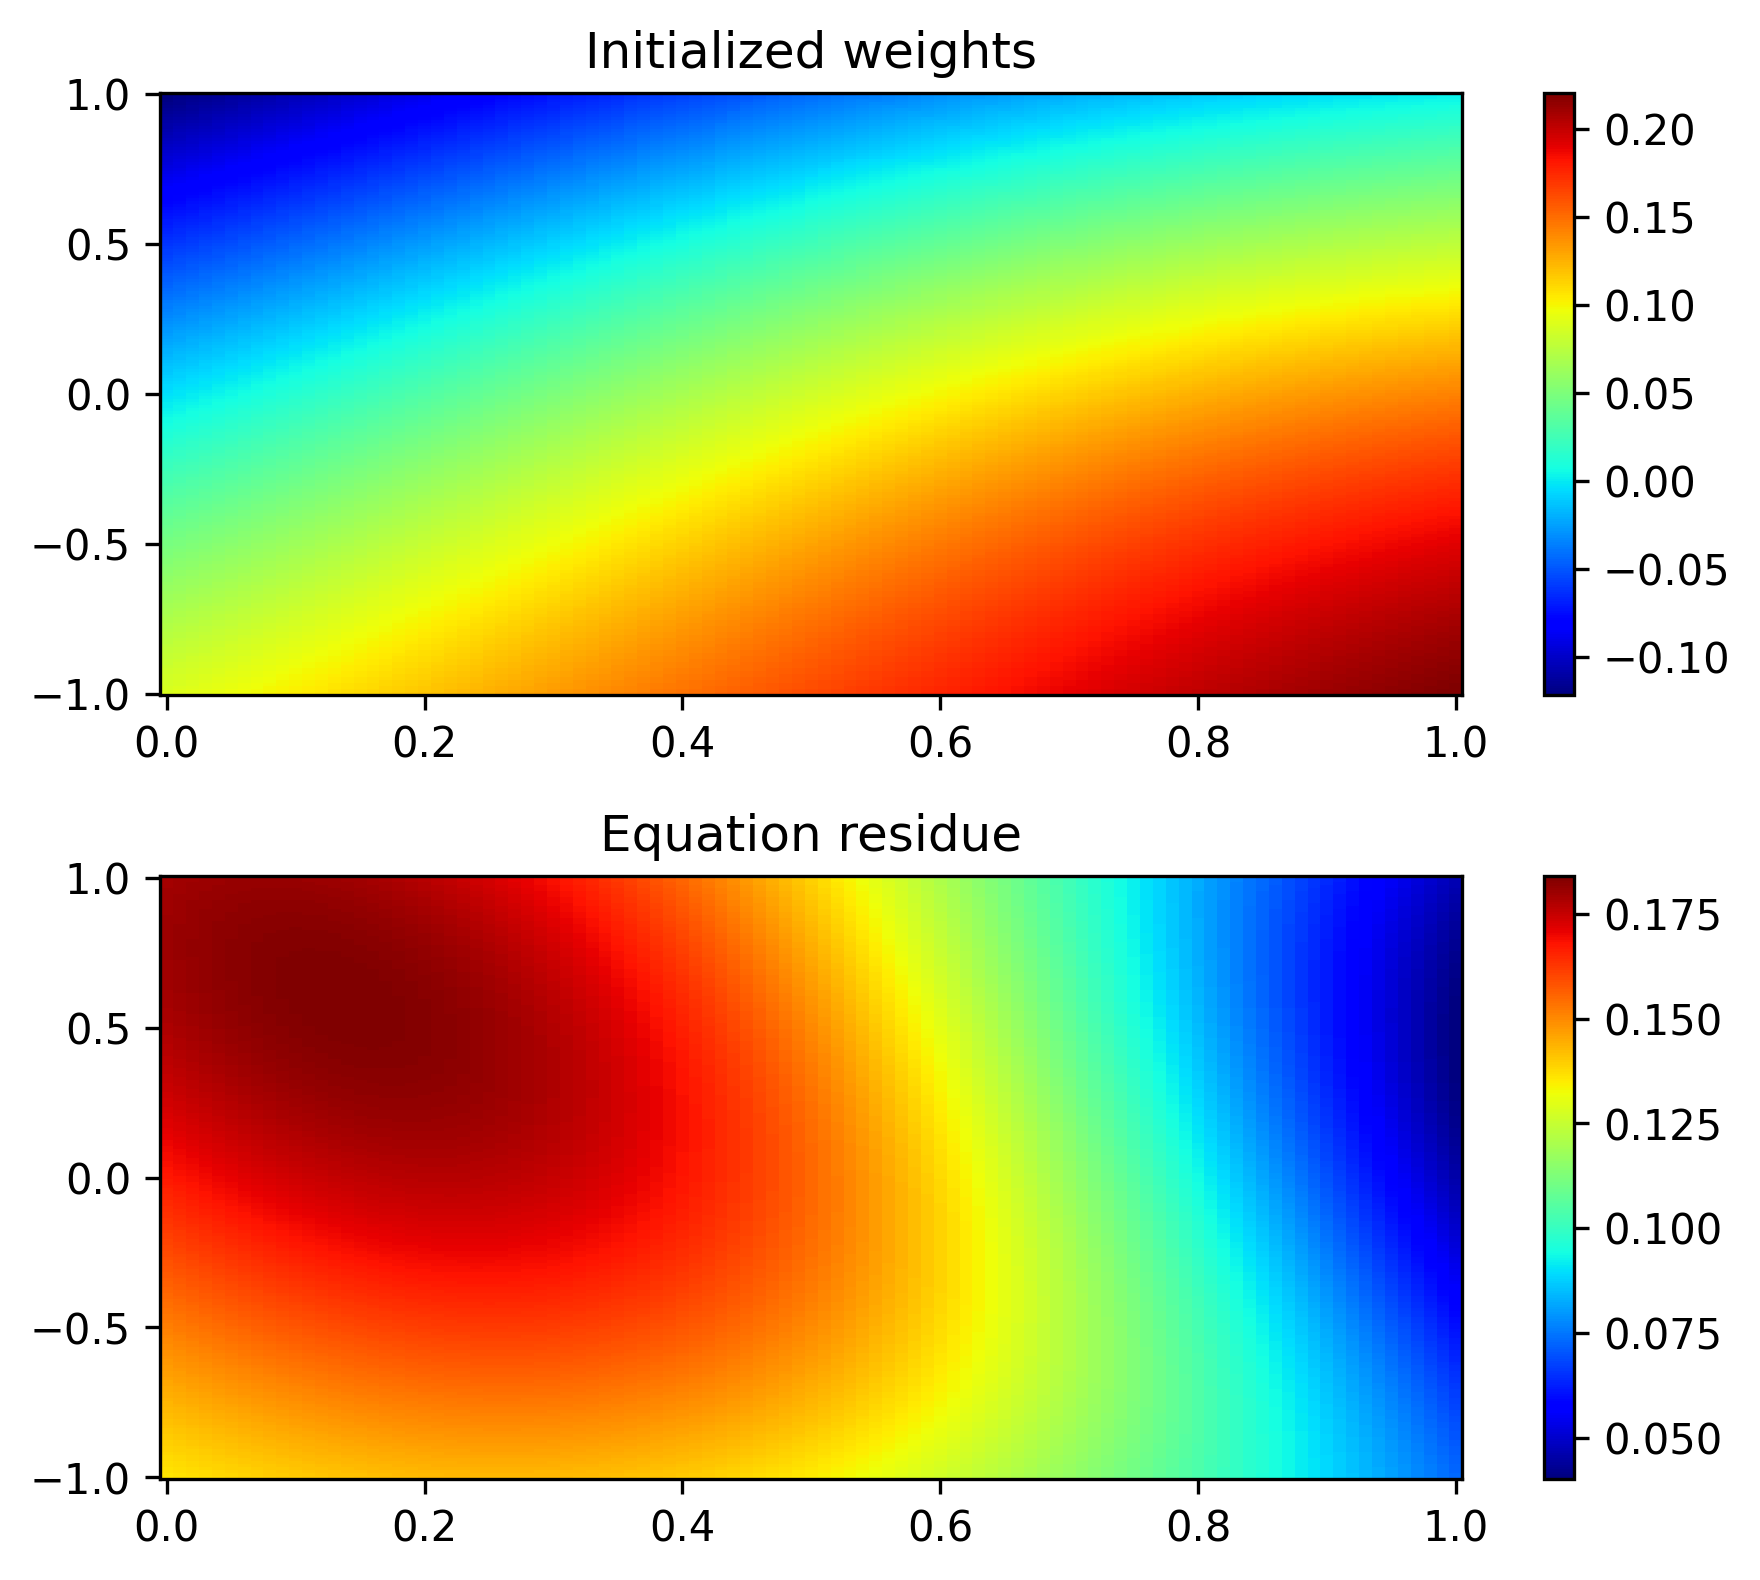

Step: 0 | Loss: 1.0000e+00 | Loss_d: 2.2525e-01 | Loss_e: 1.9573e-02


Step: NaN | Loss: 8.9152e-01 | Loss_d: 2.0078e-01 | Loss_e: 1.7733e-02
Step: NaN | Loss: 3.2005e+01 | Loss_d: 7.1670e+00 | Loss_e: 1.0468e+00
Step: NaN | Loss: 9.0290e-01 | Loss_d: 2.0261e-01 | Loss_e: 2.5346e-02
Step: NaN | Loss: 8.7465e-01 | Loss_d: 1.9664e-01 | Loss_e: 2.0806e-02
Step: NaN | Loss: 8.7140e-01 | Loss_d: 1.9584e-01 | Loss_e: 2.1491e-02
Step: NaN | Loss: 8.6045e-01 | Loss_d: 1.9303e-01 | Loss_e: 2.4725e-02
Step: NaN | Loss: 8.8473e-01 | Loss_d: 1.9500e-01 | Loss_e: 6.0164e-02
Step: NaN | Loss: 8.5192e-01 | Loss_d: 1.9047e-01 | Loss_e: 3.0878e-02
Step: NaN | Loss: 8.2828e-01 | Loss_d: 1.8495e-01 | Loss_e: 3.2445e-02
Step: NaN | Loss: 9.4774e-01 | Loss_d: 1.9844e-01 | Loss_e: 1.6894e-01
Step: NaN | Loss: 8.1989e-01 | Loss_d: 1.8251e-01 | Loss_e: 3.7709e-02
 Total iterations: 11


/usr/local/lib/python3.10/dist-packages/scipy/io/matlab/_mio5.py:494: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  narr = np.asanyarray(source)


[[ 781066781 1120776553]
 [2653198741 1770967201]
 [ 179802120 1816380397]
 [3816117996 1883632429]]
0.01


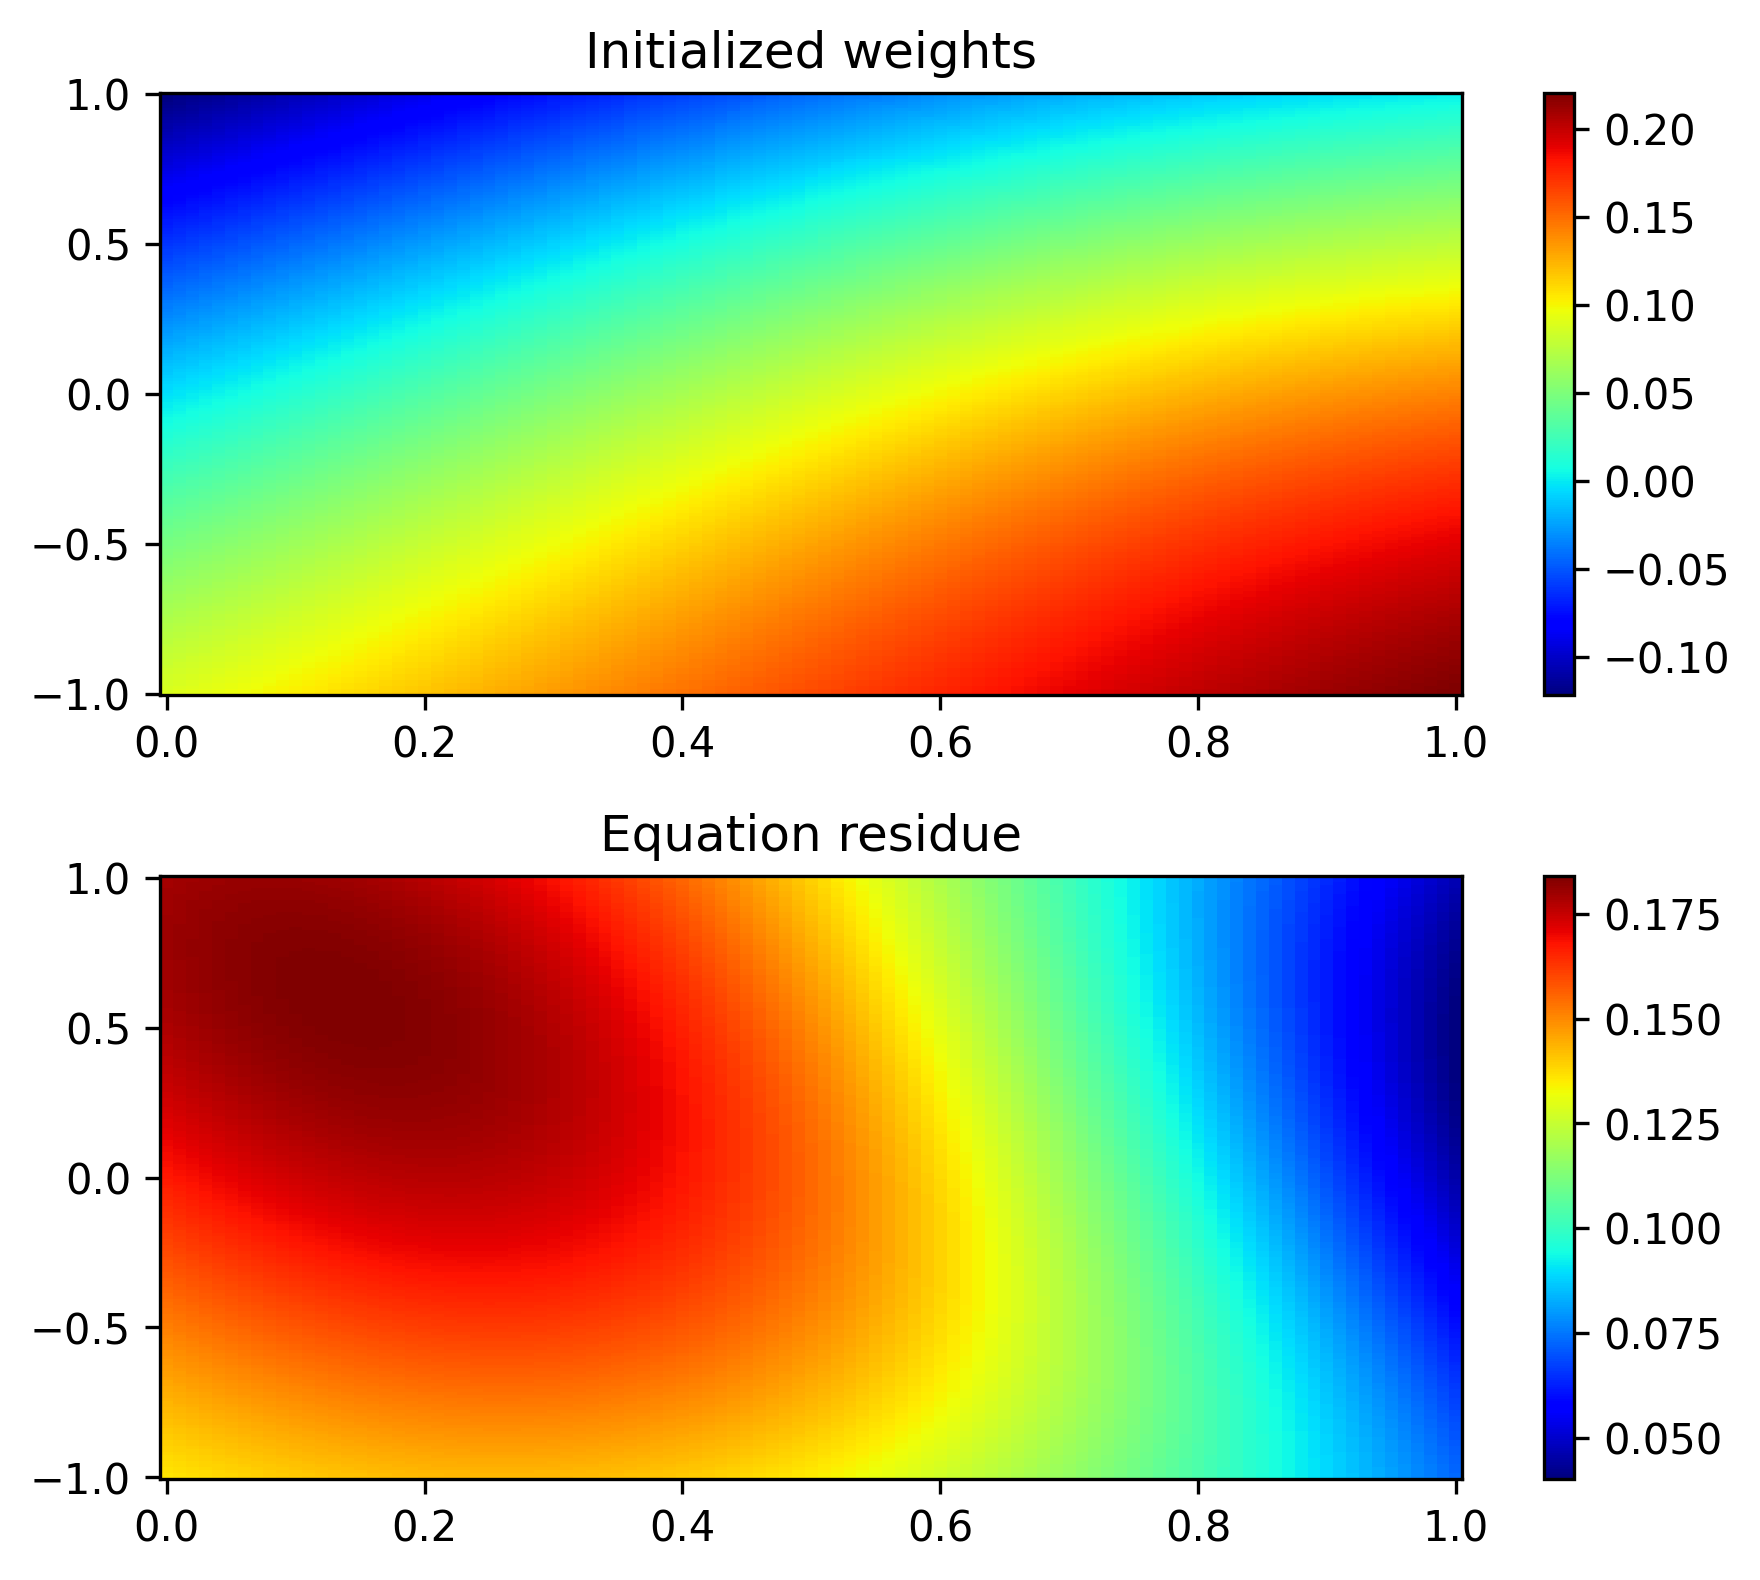

Step: 0 | Loss: 1.0000e+00 | Loss_d: 5.8597e-01 | Loss_e: 2.5247e-02


Step: NaN | Loss: 6.0194e-01 | Loss_d: 3.4645e-01 | Loss_e: 7.7847e-02
Step: NaN | Loss: 1.1216e+01 | Loss_d: 6.5350e+00 | Loss_e: 6.5524e-01
Step: NaN | Loss: 1.0420e+01 | Loss_d: 6.0838e+00 | Loss_e: 4.8530e-01
Step: NaN | Loss: 7.7227e+00 | Loss_d: 4.5410e+00 | Loss_e: 3.7771e-02
Step: NaN | Loss: 2.7482e+00 | Loss_d: 1.5971e+00 | Loss_e: 2.0182e-01
Step: NaN | Loss: 8.0671e-01 | Loss_d: 4.6347e-01 | Loss_e: 1.1274e-01
Step: NaN | Loss: 5.9276e-01 | Loss_d: 3.3995e-01 | Loss_e: 8.8849e-02
Step: NaN | Loss: 5.8037e-01 | Loss_d: 3.3342e-01 | Loss_e: 8.1300e-02
Step: NaN | Loss: 7.0968e-01 | Loss_d: 4.1159e-01 | Loss_e: 6.0504e-02
Step: NaN | Loss: 5.8034e-01 | Loss_d: 3.3348e-01 | Loss_e: 8.0473e-02
Step: NaN | Loss: 5.7928e-01 | Loss_d: 3.3299e-01 | Loss_e: 7.9179e-02
Step: NaN | Loss: 5.7872e-01 | Loss_d: 3.3315e-01 | Loss_e: 7.4225e-02
Step: NaN | Loss: 5.7826e-01 | Loss_d: 3.3269e-01 | Loss_e: 7.6141e-02
 Total iterations: 13


In [88]:
#@title Run Problem

def run_burger_pinn(p = 2):
    """ find the root directory """
    # rootdir = Path(__file__).parent
    rootdir = Path("/content/drive/MyDrive/Stanford/1_31")

    precision = jnp.float64
    # change JAX to double precision
    config.update('jax_enable_x64', True)

    """Set the conditions of the problem"""

    # select the random seed
    seed = 1234
    key = random.PRNGKey(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    # jnp.random.seed(seed)

    # create the subkeys
    keys = random.split(key, 4)
    print(f"{keys}")

    # select the size of neural network
    n_hl = 6
    n_unit = 30
    scl = 1
    epsil = 1
    nu = 0.01

    # activation function
    act_s = 0

    # number of sampling points
    N_col = 10000
    N_bd = 100

    # set the size of domain
    ds = 1.
    lmt = jnp.array([[-ds], [ds]])

    '''
    loading the dataset and define the domain
    =============================================
    '''
    N_t = 101
    N_x = 201
    t = jnp.linspace(0, 1, N_t)
    x = jnp.linspace(-1, 1, N_x)

    T, X = jnp.meshgrid(t, x)
    X_star = jnp.hstack((T.flatten()[:, None], X.flatten()[:, None]))

    # Domain bounds
    lb = jnp.array([0, -1])  # X_star.min(0)
    ub = jnp.array([1, 1])   # X_star.max(0)
    limit = [lb, ub]
    lw = [1e-1]

    # initialize the weights and biases of the network
    trained_params = sol_init_MLP(keys[0], n_hl, n_unit)

    # create the solution function
    pred_u = sol_pred_create(limit, scl, epsil=epsil, act_s=act_s)

    # create the data function
    dataf, weights = data_func_create_burger(N_col, N_bd, ds)
    data = dataf()

    # calculate the loss function, normalized based on initial loss set to 1
    NN_loss = loss_create(pred_u, nu, lw, loss_ref=1, p = p)
    loss0 = NN_loss(trained_params, data)[0]
    NN_loss = loss_create(pred_u, nu, lw, loss_ref=loss0, p = p)

    # Plot initialized weight solution
    plotter = PINN_Plotter(loss_dict = {}, rootdir = rootdir, filename = {"loss": f"burger_loss_p{p}_initial.png", "results": f"burger_sol_{p}p_initial.png"},
                dpi = 300, precision = precision, fontsize = {'title': 15, 'subtitle': 12}, Z = {'T': T, 'X': X},
                trained_params = trained_params, pred_u = pred_u, show = True, burger_params = {'nu': nu}, title = {'burger': "Initialized weights"})
    plotter.plot_burger()

    """Training using Adam"""

    # set the learning rate for Adam
    lr = 5e-3
    # training the neural network
    start_time = time.time()
    # set the training iteration
    n_iters_train = [10, 10] # number of iterations to train for, approximately
    n_iters = [] # exact number of iterations trained for each method
    methods = ["adam", "lbfgs"]
    loss_all = []
    for i, n_iter in enumerate(n_iters_train):
        match methods[i]:
            case "adam":
                trained_params, loss = adam_optimizer(NN_loss, trained_params, data, n_iter, lr=lr)
            case "lbfgs":
                trained_params, loss = lbfgs_optimizer(NN_loss, trained_params, data, n_iter)
        loss_all += loss
        n_iters.append(len(loss))
    loss_all = jnp.array(loss_all)

    # calculate the equation residue
    f_up = lambda z: pred_u(trained_params, z)

    # calculate the solution
    u_p = f_up(X_star)
    f_p = gov_eqn(f_up, X_star, nu)

    U = jnp.reshape(u_p, X.shape)
    F = jnp.reshape(f_p, X.shape)

    # generate the last loss
    # n_iters = [len(loss1), len(loss2)]
    # loss_all = jnp.array(loss1+loss2)
    mdic = {"params": trained_params['net_u'], 'T': T, 'X': X, "U": U, "F": F, "loss_all": loss_all, "limit": limit,
        "scl": scl, "epsil": epsil, "act_s": act_s, "methods": methods, "n_iters": n_iters, "nu": nu}
    FileName = burger_filename(nu, p)
    FilePath = str(rootdir.joinpath(FileName))
    scipy.io.savemat(FilePath, mdic)

def burger_filename(nu, p):
    return f'Burgers_2d_basic_nu={nu:.2f}_p={p}.mat'

run_burger_pinn(p = 2)
run_burger_pinn(p = 10)

In [ ]:
######################################################################
############################# Plotting ###############################
######################################################################

rootdir = Path("/content/drive/MyDrive/Stanford/1_31")

for p in [2, 10]:
    FileName = burger_filename(nu = 0.01, p = p)
    FilePath = str(rootdir.joinpath(FileName))
    mdic = scipy.io.loadmat(FilePath)

    pred_u = sol_pred_create(mdic['limit'], mdic['scl'], epsil = mdic['epsil'], act_s = mdic['act_s'].item())

    mdic = scipy.io.loadmat(FilePath)
    loss_dict = {'loss': mdic['loss_all'][:, 0], 'loss_d': mdic['loss_all'][:, 1], 'loss_e': mdic['loss_all'][:, 2]}
    burger_params = {"nu": mdic['nu'].item()}

    precision = jnp.float64
    plotter = PINN_Plotter(loss_dict = loss_dict, rootdir = rootdir, filename = {"loss": f"burger_loss_p{p}.png", "results": f"burger_sol_{p}p.png"},
                           methods = ["adam", "lbfgs"], n_iters = mdic['n_iters'][0], dpi = 300, precision = precision,
                           fontsize = {'title': 15, 'subtitle': 12}, Z = {'T': mdic['T'], 'X': mdic['X']},
                           trained_params = {'net_u': mdic['params']}, pred_u = pred_u, show = True, burger_params = burger_params)
    plotter.plot_loss()
    plotter.plot_burger()

# lb = jnp.array([0, -0.1])  # X_star.min(0)
# ub = jnp.array([1, 0.1])   # X_star.max(0)
# limit = [lb, ub]